### Descrição - Modelo Serial Dependent (lags)

Utiliza todo o conjunto de dados ``train.csv`` para fazer a previsão daquele mês em diante. Utiliza as estratégias de previsão Multioutput, DirecRec e Direct.

Objetivo de criar um arquivo para **submeter no kaggle** e avaliar a performance.


### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from random import sample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from warnings import simplefilter
simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure",
       autolayout=True,
       figsize=(11, 7),
       titlesize=18,
       titleweight='bold',
      )
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=16,
       titlepad=10,
      )
plot_params = dict(color="0.75",
                   style=".-",
                   markeredgecolor="0.25",
                   markerfacecolor="0.25",
                  )
%config InlineBackend.figure_format = 'retina'


### Load datasets

In [3]:
cols = ["cfips", "microbusiness_density", "active"]
train_df = pd.read_csv('./files/train.csv',
                      usecols=["first_day_of_month"] + cols,
                      parse_dates=['first_day_of_month'],
                      index_col='first_day_of_month',
                      ).to_period('D').reindex(columns=cols)

train_df.index.names = ['Month']
train_df = train_df.drop("active", axis=1)

print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 122265 entries, 2019-08-01 to 2022-10-01
Freq: D
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.8 MB
None


,cfips,microbusiness_density
Month,,
2019-08-01,1001,3.007682
2019-09-01,1001,2.884870
2019-10-01,1001,3.055843
2019-11-01,1001,2.993233
2019-12-01,1001,2.993233


In [4]:
test_df = pd.read_csv('./files/test.csv')
samp_sub_df = pd.read_csv('./files/sample_submission.csv')
display(test_df.head())
display(samp_sub_df.head())


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


### Setting Forecast parameters

In [5]:
# number of lags to use in X_train
nlags = 4

# number of steps between forecast origin and forecast horizon
nlead_time = 1

# number of forecast values to predict
nsteps = 1


#### Pivoted dataframe

In [6]:
# make pivot, setting date by index and cfips in columns
train_pivoted = train_df.pivot_table(index='Month', columns='cfips', values='microbusiness_density')
train_pivoted.tail()

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2022-06-01,3.346197,8.507496,1.191678,1.275998,1.773202,0.937421,1.983687,2.724583,1.468978,1.117345,...,1.713062,6.101229,3.212966,113.19935,7.739897,2.783238,25.652266,3.906035,3.126551,1.803249
2022-07-01,3.437971,8.573463,1.216926,1.326588,1.831783,0.950089,2.042414,2.782648,1.548280,1.141118,...,1.766595,6.191458,3.184532,114.09351,7.884691,2.836282,25.939260,3.981813,3.225807,1.803249
2022-08-01,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,1.766595,6.221535,3.156099,113.44169,7.779387,2.811320,26.085369,3.974924,3.209264,1.785395
2022-09-01,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609,...,1.766595,6.178568,3.170316,128.26224,7.792550,2.811320,26.090586,3.995591,3.209264,1.785395
2022-10-01,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345,...,1.713062,6.217238,3.212966,227.75665,7.792550,2.823801,26.273220,4.009369,3.126551,1.785395


In [7]:
# select the period for forecasting and drop on train set
# y_test = train_pivoted.iloc[-nsteps:, :]    Don't have y_test because we will forecast in the months 2022-11-01 to 2023-06-01
# train_pivoted = train_pivoted.drop(y_test.index, axis=0)
# y_test_period = y_test.index
# X_test_period = X_fore.index

# features lags to make forecast
X_fore = train_pivoted.iloc[-nlags:, :]

# set period to forecast
X_fore_period = pd.date_range(start="2022-11", end="2023-06", periods=None, freq="MS").to_period("D")
X_fore_period.name = "Month"


In [8]:
# y_test_period

In [9]:
X_fore_period

PeriodIndex(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
             '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
            dtype='period[D]', name='Month')

In [10]:
# y_test

In [11]:
X_fore

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2022-07-01,3.437971,8.573463,1.216926,1.326588,1.831783,0.950089,2.042414,2.782648,1.548280,1.141118,...,1.766595,6.191458,3.184532,114.09351,7.884691,2.836282,25.939260,3.981813,3.225807,1.803249
2022-08-01,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,1.766595,6.221535,3.156099,113.44169,7.779387,2.811320,26.085369,3.974924,3.209264,1.785395
2022-09-01,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609,...,1.766595,6.178568,3.170316,128.26224,7.792550,2.811320,26.090586,3.995591,3.209264,1.785395
2022-10-01,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345,...,1.713062,6.217238,3.212966,227.75665,7.792550,2.823801,26.273220,4.009369,3.126551,1.785395


### Prepare features & target series

In [12]:
# setup the feature dataframe with the corresponding lags and lead time
def make_lags(ts, nlags, lead_time):
    
    return pd.concat({f'y_lag_{lag}': ts.shift(lag) for lag in range(lead_time, nlags + lead_time)}, axis=1)


In [13]:
# Four weeks of lag features
y = train_pivoted.copy()
X = make_lags(y, nlags, nlead_time).fillna(0.0)
display(y.head())
X.head()

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2019-08-01,3.007682,7.239156,1.073138,1.310777,1.544148,0.926372,0.674981,2.691544,1.486542,1.104277,...,1.150575,5.916088,4.062681,30.183279,6.115724,2.640386,26.433363,4.612016,2.603246,1.548594
2019-09-01,2.884870,7.290936,0.995794,1.305176,1.575892,0.998556,0.739265,2.703752,1.355156,1.089747,...,1.150575,5.894528,3.888567,31.712736,6.142085,2.858371,26.611856,4.338306,2.683593,1.530794
2019-10-01,3.055843,7.425439,1.160149,1.254761,1.546415,0.974495,0.713551,2.693764,1.355156,1.084903,...,1.150575,5.881592,3.903076,31.990431,6.181626,2.913635,26.736261,4.420419,2.635385,1.530794
2019-11-01,2.993233,7.426071,1.000628,1.254761,1.573625,1.022618,1.054256,2.739270,1.362664,1.084903,...,1.200600,5.954897,3.845038,32.776520,6.234348,3.008812,26.920164,4.372520,2.683593,1.601994
2019-12-01,2.993233,7.470274,1.000628,1.265965,1.555485,1.034649,1.054256,2.729281,1.343894,1.089747,...,1.200600,5.911776,3.845038,32.806427,6.273890,3.088637,26.903938,4.310935,2.635385,1.584194


y_lag_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2019-08-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2019-09-01  3.007682  7.239156  1.073138  1.310777  1.544148  0.926372   
2019-10-01  2.884870  7.290936  0.995794  1.305176  1.575892  0.998556   
2019-11-01  3.055843  7.425439  1.160149  1.254761  1.546415  0.974495   
2019-12-01  2.993233  7.426071  1.000628  1.254761  1.573625  1.022618   

                                                    ...   y_lag_4            \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2019-08-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2019-09-01  0.674981  2.691544  1.486542  1.104277  ...  0.000000  0.000000   
2019-10-01  0.739265  2.703752  1.355156  1.089747  ...  0.000000  0.000000   
2019-11-01  0.713551  2.693764  1.355156  1.084903  ...  0.000000  0.000000   
2019-12-01  1.054256  2.739270  1.362664  1.084903  ...  1.150575  5.916088   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2019-08-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-09-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-10-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-11-01  0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
2019-12-01  4.062681  30.183279  6.115724  2.640386  26.433363  4.612016   

                                
cfips          56043     56045  
Month                           
2019-08-01  0.000000  0.000000  
2019-09-01  0.000000  0.000000  
2019-10-01  0.000000  0.000000  
2019-11-01  0.000000  0.000000  
2019-12-01  2.603246  1.548594  

[5 rows x 12540 columns]

In [14]:
# setup the dataframe with the corresponding shifs steps
def make_multistep_target(ts, nsteps):
    
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in range(nsteps)}, axis=1)


In [15]:
# Eight-week forecast
y = make_multistep_target(y, nsteps).dropna()
print("y multistep (forecast horizon): ")
display(y.tail())

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)
print("\ny align: ")
display(y.tail())
print("\nX align: ")
X.tail()

y multistep (forecast horizon): 


y_step_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2022-06-01  3.346197  8.507496  1.191678  1.275998  1.773202  0.937421   
2022-07-01  3.437971  8.573463  1.216926  1.326588  1.831783  0.950089   
2022-08-01  3.423852  8.491150  1.196728  1.292861  1.836289  0.962757   
2022-09-01  3.442677  8.341701  1.206827  1.315346  1.852060  0.975424   
2022-10-01  3.463856  8.359798  1.232074  1.287240  1.831783  0.988092   

                                                    ...                      \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2022-06-01  1.983687  2.724583  1.468978  1.117345  ...  1.713062  6.101229   
2022-07-01  2.042414  2.782648  1.548280  1.141118  ...  1.766595  6.191458   
2022-08-01  2.107667  2.788231  1.521846  1.131609  ...  1.766595  6.221535   
2022-09-01  2.166395  2.809447  1.502964  1.131609  ...  1.766595  6.178568   
2022-10-01  2.185970  2.800514  1.442544  1.117345  ...  1.713062  6.217238   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2022-06-01  3.212966  113.19935  7.739897  2.783238  25.652266  3.906035   
2022-07-01  3.184532  114.09351  7.884691  2.836282  25.939260  3.981813   
2022-08-01  3.156099  113.44169  7.779387  2.811320  26.085369  3.974924   
2022-09-01  3.170316  128.26224  7.792550  2.811320  26.090586  3.995591   
2022-10-01  3.212966  227.75665  7.792550  2.823801  26.273220  4.009369   

                                
cfips          56043     56045  
Month                           
2022-06-01  3.126551  1.803249  
2022-07-01  3.225807  1.803249  
2022-08-01  3.209264  1.785395  
2022-09-01  3.209264  1.785395  
2022-10-01  3.126551  1.785395  

[5 rows x 3135 columns]


y align: 


y_step_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2022-06-01  3.346197  8.507496  1.191678  1.275998  1.773202  0.937421   
2022-07-01  3.437971  8.573463  1.216926  1.326588  1.831783  0.950089   
2022-08-01  3.423852  8.491150  1.196728  1.292861  1.836289  0.962757   
2022-09-01  3.442677  8.341701  1.206827  1.315346  1.852060  0.975424   
2022-10-01  3.463856  8.359798  1.232074  1.287240  1.831783  0.988092   

                                                    ...                      \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2022-06-01  1.983687  2.724583  1.468978  1.117345  ...  1.713062  6.101229   
2022-07-01  2.042414  2.782648  1.548280  1.141118  ...  1.766595  6.191458   
2022-08-01  2.107667  2.788231  1.521846  1.131609  ...  1.766595  6.221535   
2022-09-01  2.166395  2.809447  1.502964  1.131609  ...  1.766595  6.178568   
2022-10-01  2.185970  2.800514  1.442544  1.117345  ...  1.713062  6.217238   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2022-06-01  3.212966  113.19935  7.739897  2.783238  25.652266  3.906035   
2022-07-01  3.184532  114.09351  7.884691  2.836282  25.939260  3.981813   
2022-08-01  3.156099  113.44169  7.779387  2.811320  26.085369  3.974924   
2022-09-01  3.170316  128.26224  7.792550  2.811320  26.090586  3.995591   
2022-10-01  3.212966  227.75665  7.792550  2.823801  26.273220  4.009369   

                                
cfips          56043     56045  
Month                           
2022-06-01  3.126551  1.803249  
2022-07-01  3.225807  1.803249  
2022-08-01  3.209264  1.785395  
2022-09-01  3.209264  1.785395  
2022-10-01  3.126551  1.785395  

[5 rows x 3135 columns]


X align: 


y_lag_1                                                    \
cfips          1001      1003      1005      1007      1009      1011    
Month                                                                    
2022-06-01  3.313253  7.907365  1.186629  1.247892  1.748417  0.912085   
2022-07-01  3.346197  8.507496  1.191678  1.275998  1.773202  0.937421   
2022-08-01  3.437971  8.573463  1.216926  1.326588  1.831783  0.950089   
2022-09-01  3.423852  8.491150  1.196728  1.292861  1.836289  0.962757   
2022-10-01  3.442677  8.341701  1.206827  1.315346  1.852060  0.975424   

                                                    ...   y_lag_4            \
cfips          1013      1015      1017      1019   ...     56027     56029   
Month                                               ...                       
2022-06-01  1.807504  2.691084  1.487859  1.245721  ...  1.820128  5.882100   
2022-07-01  1.983687  2.724583  1.468978  1.117345  ...  1.820128  5.989516   
2022-08-01  2.042414  2.782648  1.548280  1.141118  ...  1.766595  6.023890   
2022-09-01  2.107667  2.788231  1.521846  1.131609  ...  1.766595  6.058262   
2022-10-01  2.166395  2.809447  1.502964  1.131609  ...  1.713062  6.101229   

                                                                          \
cfips          56031      56033     56035     56037      56039     56041   
Month                                                                      
2022-06-01  3.284049  102.14349  7.687245  2.892446  25.438322  3.954258   
2022-07-01  3.241399  104.88029  7.897854  2.848763  25.636610  4.023147   
2022-08-01  3.227182  105.97919  7.858365  2.851883  25.626175  4.064481   
2022-09-01  3.212966  106.20900  7.832039  2.820681  25.506157  3.885368   
2022-10-01  3.212966  113.19935  7.739897  2.783238  25.652266  3.906035   

                                
cfips          56043     56045  
Month                           
2022-06-01  3.027295  1.749688  
2022-07-01  3.010753  1.767542  
2022-08-01  2.977668  1.767542  
2022-09-01  2.944582  1.803249  
2022-10-01  3.126551  1.803249  

[5 rows x 12540 columns]

### Cfips encoding

In [16]:
le = LabelEncoder()

X_train = X.stack("cfips").reset_index("cfips")   # wide to long
X_train["cfips"] = le.fit_transform(X_train["cfips"])

y_train = y.stack('cfips')  # wide to long

display(X_train)
display(y_train)

,cfips,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Month,,,,,
2019-08-01,0,0.000000,0.000000,0.000000,0.000000
2019-08-01,1,0.000000,0.000000,0.000000,0.000000
2019-08-01,2,0.000000,0.000000,0.000000,0.000000
2019-08-01,3,0.000000,0.000000,0.000000,0.000000
2019-08-01,4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2022-10-01,3130,2.811320,2.811320,2.836282,2.783238
2022-10-01,3131,26.090586,26.085369,25.939260,25.652266
2022-10-01,3132,3.995591,3.974924,3.981813,3.906035


y_step_1
Month      cfips           
2019-08-01 1001    3.007682
           1003    7.239156
           1005    1.073138
           1007    1.310777
           1009    1.544148
...                     ...
2022-10-01 56037   2.823801
           56039  26.273220
           56041   4.009369
           56043   3.126551
           56045   1.785395

[122265 rows x 1 columns]

In [17]:
# reshapes the test dataframe to match training dataframe
def reshape_Xfore(df_train, df_test, encoder, fore_origin):
    df = pd.DataFrame(df_test.sort_index(ascending=False).values.T,
                      columns=df_train.columns[1:],
                      index=df_test.columns,
                     ).reset_index()

    # convert the index values to a date using the date string
    df.index = [fore_origin[0] for _ in range(len(df.index))]
    df.index.name = df_train.index.name
    
    df["cfips"] = encoder.transform(df["cfips"])
    
    return df

X_fore = reshape_Xfore(X_train, X_fore, le, X_fore_period)
# y_test = pd.DataFrame(y_test.stack("cfips"), columns=["microbusiness_density"])


In [18]:
X_fore

,cfips,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Month,,,,,
2022-11-01,0,3.463856,3.442677,3.423852,3.437971
2022-11-01,1,8.359798,8.341701,8.491150,8.573463
2022-11-01,2,1.232074,1.206827,1.196728,1.216926
2022-11-01,3,1.287240,1.315346,1.292861,1.326588
2022-11-01,4,1.831783,1.852060,1.836289,1.831783
...,...,...,...,...,...
2022-11-01,3130,2.823801,2.811320,2.811320,2.836282
2022-11-01,3131,26.273220,26.090586,26.085369,25.939260
2022-11-01,3132,4.009369,3.995591,3.974924,3.981813


In [19]:
# y_test

In [20]:
# reshapes the df_pred dataframe to match y_train
def reshape_ypred(df_test, df_pred, encoder, horizon_period):
    
    df_pred["cfips"] = encoder.inverse_transform(df_test["cfips"])
    df_pred = df_pred.set_index("cfips", append=True)
    df_pred.columns = horizon_period
    
    df_pred = pd.DataFrame(df_pred.reset_index("Month", drop=True).stack(),
                          columns=["microbusiness_density"],
                           )\
                          .reset_index("cfips")\
                          .pivot_table(index='Month', columns='cfips', values='microbusiness_density')\
                          .stack("cfips")

    df_pred = pd.DataFrame(df_pred, columns=["microbusiness_density"])    
        
    return df_pred


### SMAPE

In [21]:
# calculate SMAPE between forecasts and actual values
def smape(ts_true, ts_pred):
    
    y_true = ts_true.values.reshape(-1)
    y_pred = ts_pred.values.reshape(-1)
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = np.abs(y_pred) + np.abs(y_true)
        
    df = pd.DataFrame(index=range(max(numerator.shape)), columns=["Numerator", "Denominator"])
    df["Numerator"] = numerator.T
    df["Denominator"] = denominator.T
    
    df = df[df["Denominator"] != 0.0]   # Drop rows where column "Denominator" is equal to 0

    return 100 * np.mean(df["Numerator"].values/df["Denominator"].values)


### Make submission file

In [22]:
def sub_file(sample_sub_df, df_pred):
    
    df_pred = df_pred.reset_index()
    df_pred["Month"] = df_pred["Month"].astype(str)
    df_pred["cfips"] = df_pred["cfips"].astype(str)
    df_pred["row_id"] = df_pred["cfips"] + "_" + df_pred["Month"]    
    df_pred = df_pred.drop(["Month", "cfips"], axis=1).reindex(columns=sample_sub_df.columns)
    
    sub_file_final = sample_sub_df.drop("microbusiness_density", axis=1).merge(df_pred, how="left", on="row_id")
    empty_values = sub_file_final.isna().sum().sum()
    
    return empty_values, sub_file_final


### Direct-Recursive Strategy & Model

In [ ]:
# implements the direct-recursive forecast
model = RegressorChain(base_estimator=XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)

y_pred = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y_train.columns).clip(0.0)
y_pred = reshape_ypred(X_fore, y_pred, le, X_fore_period)


In [ ]:
emp_vals, sub_df = sub_file(samp_sub_df, y_pred)

# save submmission file
sub_df.to_csv('./submission_files/submission_DirecRec_serial.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)


In [ ]:
y_fit

In [ ]:
y_pred

In [ ]:
# Plot some prediction
train_smape = smape(y_train, y_fit)
# test_smape = smape(y_test, y_pred)
print(f"Train SMAPE: {train_smape:.2f}\n")

# Plot
cfips_ex = sample(list(train_pivoted.columns), 3)
# y_test_plot = y_test.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
# y_fit_plot = y_fit.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
y_pred_plot = y_pred.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()

axs = train_pivoted.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
# axs = y_test_plot.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_plot.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"DirecRec Strategy - cfips {cfips_ex}")

### Direct strategy & model

In [ ]:
# implements the direct strategy
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)

y_pred = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y_train.columns).clip(0.0)
y_pred = reshape_ypred(X_fore, y_pred, le, X_fore_period)


In [ ]:
emp_vals, sub_df = sub_file(samp_sub_df, y_pred)

# save submmission file
sub_df.to_csv('./submission_files/submission_Direct_serial.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)


In [ ]:
# Plot some prediction
train_smape = smape(y_train, y_fit)
# test_smape = smape(y_test, y_pred)
print(f"Train SMAPE: {train_smape:.2f}\n")

# Plot
# cfips_ex = sample(list(train_pivoted.columns), 3)
# y_test_plot = y_test.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
# y_fit_plot = y_fit.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
y_pred_plot = y_pred.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()

axs = train_pivoted.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
# axs = y_test_plot.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_plot.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Direct Strategy - cfips {cfips_ex}")

### Multioutput strategy & model

In [24]:
# Create splits
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)

y_pred = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y_train.columns).clip(0.0)
# y_pred = reshape_ypred(X_fore, y_pred, le, X_fore_period)


In [ ]:
emp_vals, sub_df = sub_file(samp_sub_df, y_pred)

# save submmission file
sub_df.to_csv('./submission_files/submission_Multioutput_serial.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)


In [33]:
y_pred['cfips'] = y_fit.pivot_table(index='Month', columns='cfips', values='y_step_1').columns


Train SMAPE: 13.92



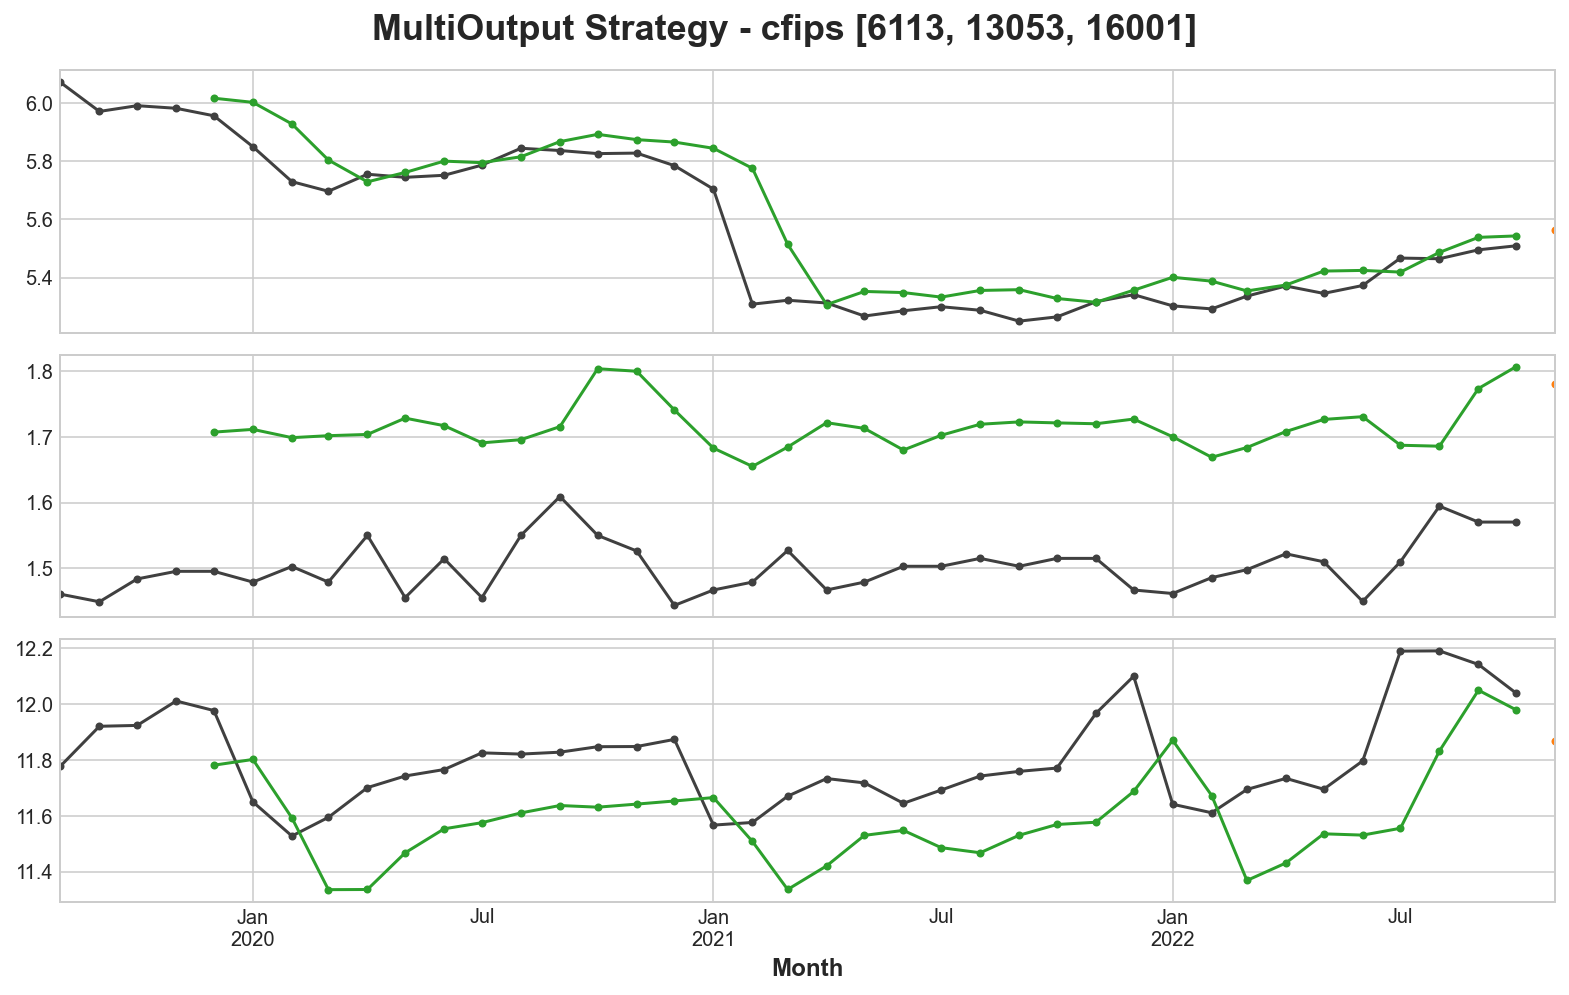

In [41]:
# Plot some prediction
train_smape = smape(y_train, y_fit)
# test_smape = smape(y_test, y_pred)
print(f"Train SMAPE: {train_smape:.2f}\n")

# Plot
cfips_ex = sample(list(train_pivoted.columns), 3)
# y_test_plot = y_test.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()
y_fit_plot = y_fit.pivot_table(index='Month', columns='cfips', values='y_step_1').copy()
y_pred_plot = y_pred.pivot_table(index='Month', columns='cfips', values='y_step_1').copy()
# y_pred_plot = y_pred.pivot_table(index='Month', columns='cfips', values='microbusiness_density').copy()

axs = train_pivoted.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = y_fit_plot.loc['2019-12-01':, cfips_ex].plot(color='C2', subplots=True, sharex=True, ax=axs, style='.-')
# axs = y_test_plot.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_plot.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"MultiOutput Strategy - cfips {cfips_ex}")